# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from collections import defaultdict
import matplotlib.pyplot as plt

#%matplotlib inline

color_bar = [["b", "b", "b", "b"], 
             ["g", "g", "g", "g"], 
             ["r", "r", "r", "r"]]

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=False):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_data_shape):
    model = Sequential()
    
    #卷積層1與池化層1
    model.add(Conv2D(filters=256,kernel_size=(3, 3), input_shape=input_data_shape, activation='relu', padding='same'))
    model.add(Dropout(rate=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層2與池化層2
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Dropout(rate=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))

#     #卷積層3與池化層3
#     model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
#     model.add(Dropout(rate=0.2))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     #卷積層3與池化層4
#     model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
#     model.add(Dropout(rate=0.2))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #建立神經網路(平坦層、隱藏層、輸出層)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(10, activation='softmax'))

    return model

In [6]:
 '''
 SGD(隨機梯度下降) - Arguments
lr: float >= 0. Learning rate.
momentum: float >= 0. Parameter that accelerates SGD in the relevant direction and dampens oscillations.
decay: float >= 0. Learning rate decay over each update.
nesterov: boolean. Whether to apply Nesterov momentum.
'''
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

'''
RMSprop- Arguments
lr: float >= 0. Learning rate.
rho: float >= 0.
epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
decay: float >= 0. Learning rate decay over each update.
'''
#rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

'''
Adam optimizer
'''
#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


'''
AdaGrad optimizer
'''
#adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

'\nAdaGrad optimizer\n'

In [7]:
## 超參數設定
OPTIMIZER = ["sgd", "rmsprop", "adam", "adagrad"]
LEARNING_RATE = [1e-2, 1e-3, 1e-4]
EPOCHS = 100
BATCH_SIZE = 64
MOMENTUM = 0.95

In [8]:
loss_result = defaultdict(list)
accu_result = defaultdict(list)

for i, lr in enumerate(LEARNING_RATE):
    for j, optr in enumerate(OPTIMIZER):
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Optimizer=%s, Learning rate = %.6f" % (optr, lr))
        
        # create model
        model = build_mlp(x_train.shape[1:])
        
        # optimizer
        if optr == "sgd":
            optimizer = optimizers.SGD(lr=lr, decay=1e-6, momentum=MOMENTUM, nesterov=True)

        if optr == "rmsprop":
            optimizer = optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)

        if optr == "adam":
            optimizer = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

        if optr == "adagrad":
            optimizer = optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)
    
        # compile model and training
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), shuffle=True)

        # Collect results
        tra_loss = "tra:%s:%s" % (str(lr), str(optr))
        val_loss = "val:%s:%s" % (str(lr), str(optr))
        loss_result[tra_loss].append(model.history.history["loss"])
        loss_result[val_loss].append(model.history.history["val_loss"])
        
        tra_accu = "tra:%s:%s" % (str(lr), str(optr))
        val_accu = "val:%s:%s" % (str(lr), str(optr))
        accu_result[tra_accu].append(model.history.history["acc"])
        accu_result[val_accu].append(model.history.history["val_acc"])


Experiment with Optimizer=sgd, Learning rate = 0.010000
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 53s 1ms/step - loss: 1.5022 - acc: 0.4591 - val_loss: 1.2410 - val_acc: 0.5767
Epoch 2/100
50000/50000 [==============================] - 50s 1ms/step - loss: 1.0715 - acc: 0.6220 - val_loss: 1.1082 - val_acc: 0.6157
Epoch 3/100
50000/50000 [==============================] - 50s 1ms/step - loss: 0.8983 - acc: 0.6821 - val_loss: 0.9307 - val_acc: 0.6804
Epoch 4/100
50000/50000 [==============================] - 50s 1ms/step - loss: 0.7625 - acc: 0.7300 - val_loss: 0.9168 - val_acc: 0.6798
Epoch 5/100
50000/50000 [==============================] - 50s 1ms/step - loss: 0.6357 - acc: 0.7763 - val_loss: 0.8027 - val_acc: 0.7222
Epoch 6/100
50000/50000 [==============================] - 50s 1ms/step - loss: 0.5357 - acc: 0.8094 - val_loss: 0.8341 - val_acc: 0.7126
Epoch 7/100
50000/50000 [==============================] - 50s 1ms

Epoch 16/100
50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 17/100
50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 18/100
50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 19/100
50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 20/100
50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 21/100
50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 22/100
50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 23/100


50000/50000 [==============================] - 53s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 32/100
50000/50000 [==============================] - 53s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 33/100
50000/50000 [==============================] - 53s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 34/100
50000/50000 [==============================] - 53s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 35/100
50000/50000 [==============================] - 53s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 36/100
50000/50000 [==============================] - 53s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 37/100
50000/50000 [==============================] - 53s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 38/100
50000/50000 [

50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 47/100
50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 48/100
50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 49/100
50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 50/100
50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 51/100
50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 52/100
50000/50000 [==============================] - 51s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 53/100
50000/50000 [

50000/50000 [==============================] - 50s 995us/step - loss: 0.0300 - acc: 0.9910 - val_loss: 1.0392 - val_acc: 0.7454
Epoch 62/100
50000/50000 [==============================] - 50s 995us/step - loss: 0.0277 - acc: 0.9919 - val_loss: 1.0449 - val_acc: 0.7476
Epoch 63/100
50000/50000 [==============================] - 50s 993us/step - loss: 0.0283 - acc: 0.9911 - val_loss: 1.0490 - val_acc: 0.7422
Epoch 64/100
50000/50000 [==============================] - 50s 995us/step - loss: 0.0263 - acc: 0.9920 - val_loss: 1.0322 - val_acc: 0.7468
Epoch 65/100
50000/50000 [==============================] - 50s 994us/step - loss: 0.0266 - acc: 0.9915 - val_loss: 1.0324 - val_acc: 0.7498
Epoch 66/100
50000/50000 [==============================] - 50s 994us/step - loss: 0.0227 - acc: 0.9931 - val_loss: 1.0634 - val_acc: 0.7456
Epoch 67/100
50000/50000 [==============================] - 50s 995us/step - loss: 0.0279 - acc: 0.9919 - val_loss: 1.0409 - val_acc: 0.7429
Epoch 68/100
50000/50000 [

50000/50000 [==============================] - 51s 1ms/step - loss: 0.5063 - acc: 0.8645 - val_loss: 1.5642 - val_acc: 0.4934
Epoch 78/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.4979 - acc: 0.8674 - val_loss: 1.4151 - val_acc: 0.7033
Epoch 79/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.5163 - acc: 0.8645 - val_loss: 1.3806 - val_acc: 0.7004
Epoch 80/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.5100 - acc: 0.8639 - val_loss: 1.5077 - val_acc: 0.6181
Epoch 81/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.5158 - acc: 0.8635 - val_loss: 1.8563 - val_acc: 0.5482
Epoch 82/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.5112 - acc: 0.8631 - val_loss: 1.3376 - val_acc: 0.6630
Epoch 83/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.5110 - acc: 0.8643 - val_loss: 1.3845 - val_acc: 0.6358
Epoch 84/100
50000/50000 [==============

50000/50000 [==============================] - 53s 1ms/step - loss: 0.0836 - acc: 0.9740 - val_loss: 1.4831 - val_acc: 0.7152
Epoch 95/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.0872 - acc: 0.9728 - val_loss: 1.4701 - val_acc: 0.7215
Epoch 96/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.0799 - acc: 0.9747 - val_loss: 1.4638 - val_acc: 0.7171
Epoch 97/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.0805 - acc: 0.9755 - val_loss: 1.4809 - val_acc: 0.7278
Epoch 98/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.0827 - acc: 0.9739 - val_loss: 1.5004 - val_acc: 0.7106
Epoch 99/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.0778 - acc: 0.9756 - val_loss: 1.4642 - val_acc: 0.7210
Epoch 100/100
50000/50000 [==============================] - 53s 1ms/step - loss: 0.0786 - acc: 0.9761 - val_loss: 1.4804 - val_acc: 0.7268
Experiment with Optimizer=adagrad, Lear

50000/50000 [==============================] - 50s 996us/step - loss: 1.5179 - acc: 0.4612 - val_loss: 1.5623 - val_acc: 0.4758
Epoch 11/100
50000/50000 [==============================] - 50s 995us/step - loss: 1.4852 - acc: 0.4734 - val_loss: 1.5318 - val_acc: 0.4896
Epoch 12/100
50000/50000 [==============================] - 50s 995us/step - loss: 1.4575 - acc: 0.4842 - val_loss: 1.5087 - val_acc: 0.4971
Epoch 13/100
50000/50000 [==============================] - 50s 995us/step - loss: 1.4332 - acc: 0.4920 - val_loss: 1.4765 - val_acc: 0.5068
Epoch 14/100
50000/50000 [==============================] - 50s 995us/step - loss: 1.4039 - acc: 0.5016 - val_loss: 1.4675 - val_acc: 0.5027
Epoch 15/100
50000/50000 [==============================] - 50s 994us/step - loss: 1.3810 - acc: 0.5114 - val_loss: 1.4382 - val_acc: 0.5273
Epoch 16/100
50000/50000 [==============================] - 50s 995us/step - loss: 1.3580 - acc: 0.5193 - val_loss: 1.4148 - val_acc: 0.5311
Epoch 17/100
50000/50000 [

50000/50000 [==============================] - 51s 1ms/step - loss: 0.2079 - acc: 0.9332 - val_loss: 0.7582 - val_acc: 0.7551
Epoch 26/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.1939 - acc: 0.9373 - val_loss: 0.7813 - val_acc: 0.7558
Epoch 27/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.1815 - acc: 0.9404 - val_loss: 0.8103 - val_acc: 0.7502
Epoch 28/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.1707 - acc: 0.9447 - val_loss: 0.8698 - val_acc: 0.7481
Epoch 29/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.1586 - acc: 0.9491 - val_loss: 0.8636 - val_acc: 0.7488
Epoch 30/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.1491 - acc: 0.9518 - val_loss: 0.8357 - val_acc: 0.7608
Epoch 31/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.1408 - acc: 0.9548 - val_loss: 0.8488 - val_acc: 0.7558
Epoch 32/100
50000/50000 [==============

50000/50000 [==============================] - 51s 1ms/step - loss: 0.1350 - acc: 0.9587 - val_loss: 0.9900 - val_acc: 0.7606
Epoch 85/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.1366 - acc: 0.9568 - val_loss: 1.2460 - val_acc: 0.7651
Epoch 86/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.1359 - acc: 0.9570 - val_loss: 1.2533 - val_acc: 0.7536
Epoch 87/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.1346 - acc: 0.9572 - val_loss: 1.2005 - val_acc: 0.7655
Epoch 88/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.1334 - acc: 0.9590 - val_loss: 1.2191 - val_acc: 0.7449
Epoch 89/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.1336 - acc: 0.9592 - val_loss: 1.2325 - val_acc: 0.7528
Epoch 90/100
50000/50000 [==============================] - 51s 1ms/step - loss: 0.1359 - acc: 0.9575 - val_loss: 1.1875 - val_acc: 0.7574
Epoch 91/100
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.9823 - acc: 0.3113 - val_loss: 1.9139 - val_acc: 0.3787
Epoch 2/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.7931 - acc: 0.3786 - val_loss: 1.8206 - val_acc: 0.4135
Epoch 3/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.7269 - acc: 0.3979 - val_loss: 1.7719 - val_acc: 0.4224A: 1s -
Epoch 4/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.6864 - acc: 0.4114 - val_loss: 1.7413 - val_acc: 0.4309
Epoch 5/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.6557 - acc: 0.4204 - val_loss: 1.7134 - val_acc: 0.4364
Epoch 6/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.6312 - acc: 0.4299 - val_loss: 1.6929 - val_acc: 0.4456
Epoch 7/100
50000/50000 [==============================] - 51s 1ms/step - loss: 1.6112 - acc: 0.4356 - val_loss: 1.

## Plot loss history

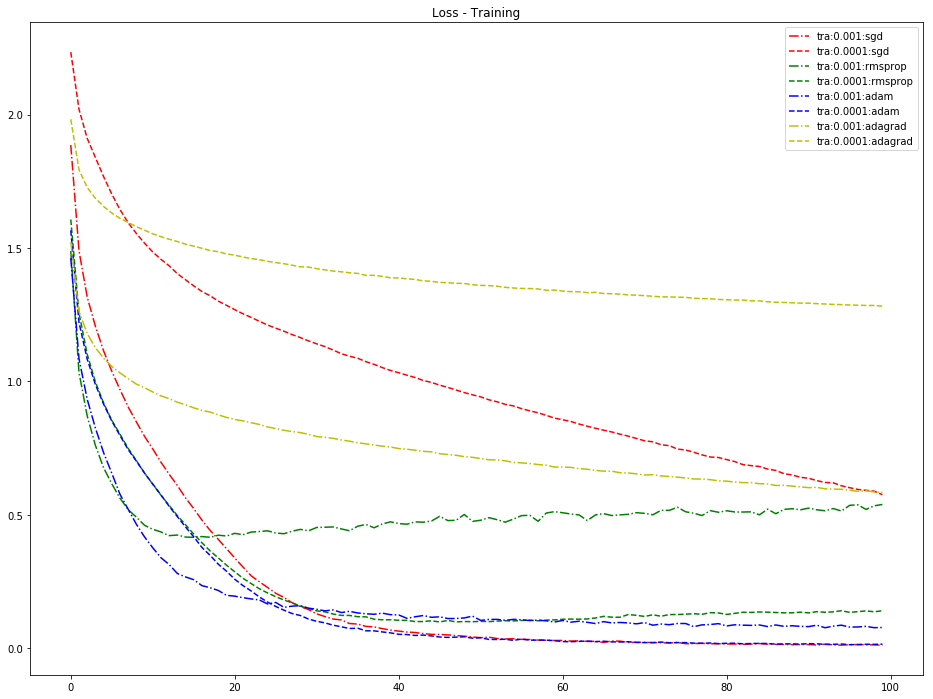

In [24]:
plt.figure(figsize=(16, 12))

#plt.plot(range(len(loss_result["tra:0.01:sgd"][0])),  loss_result["tra:0.01:sgd"][0],   ':' , label="tra:0.01:sgd",   color="r")
plt.plot(range(len(loss_result["tra:0.001:sgd"][0])), loss_result["tra:0.001:sgd"][0],  '-.', label="tra:0.001:sgd",  color="r")
plt.plot(range(len(loss_result["tra:0.0001:sgd"][0])),loss_result["tra:0.0001:sgd"][0], '--', label="tra:0.0001:sgd", color="r")

#plt.plot(range(len(loss_result["tra:0.01:rmsprop"][0])),  loss_result["tra:0.01:rmsprop"][0],   ':' , label="tra:0.01:rmsprop",   color="g")
plt.plot(range(len(loss_result["tra:0.001:rmsprop"][0])), loss_result["tra:0.001:rmsprop"][0],  '-.', label="tra:0.001:rmsprop",  color="g")
plt.plot(range(len(loss_result["tra:0.0001:rmsprop"][0])),loss_result["tra:0.0001:rmsprop"][0], '--', label="tra:0.0001:rmsprop", color="g")

#plt.plot(range(len(loss_result["tra:0.01:adam"][0])),  loss_result["tra:0.01:adam"][0],   ':' , label="tra:0.01:adam",   color="b")
plt.plot(range(len(loss_result["tra:0.001:adam"][0])), loss_result["tra:0.001:adam"][0],  '-.', label="tra:0.001:adam",  color="b")
plt.plot(range(len(loss_result["tra:0.0001:adam"][0])),loss_result["tra:0.0001:adam"][0], '--', label="tra:0.0001:adam", color="b")

#plt.plot(range(len(loss_result["tra:0.01:adagrad"][0])),  loss_result["tra:0.01:adagrad"][0],   ':' , label="tra:0.01:adagrad",   color="y")
plt.plot(range(len(loss_result["tra:0.001:adagrad"][0])), loss_result["tra:0.001:adagrad"][0],  '-.', label="tra:0.001:adagrad",  color="y")
plt.plot(range(len(loss_result["tra:0.0001:adagrad"][0])),loss_result["tra:0.0001:adagrad"][0], '--', label="tra:0.0001:adagrad", color="y")

plt.title("Loss - Training")
plt.legend(loc="upper right")
plt.show()

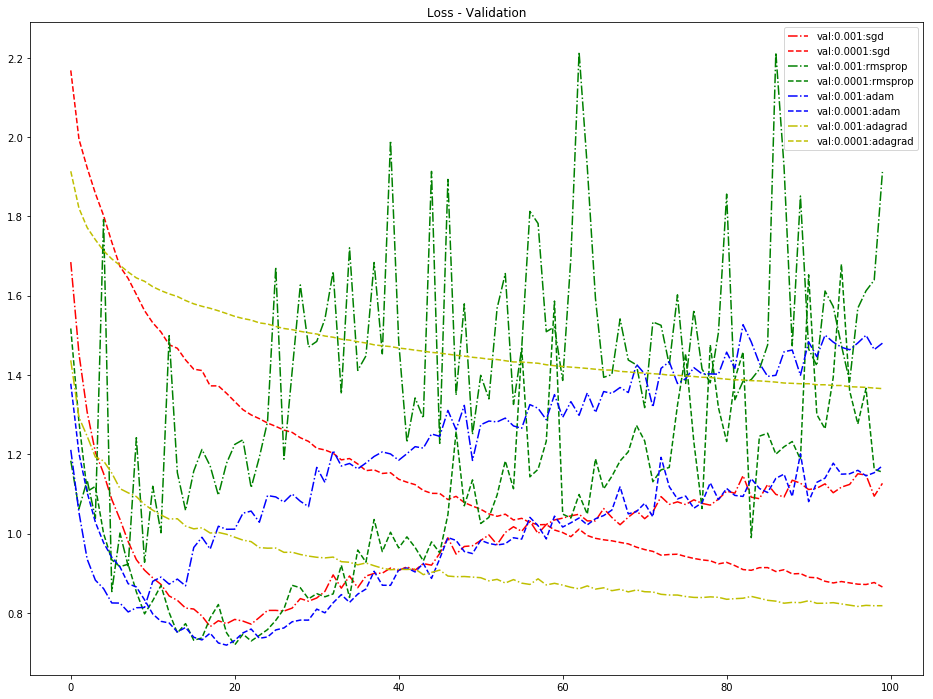

In [23]:
plt.figure(figsize=(16, 12))

#plt.plot(range(len(loss_result["val:0.01:sgd"][0])),  loss_result["val:0.01:sgd"][0],   ':' , label="val:0.01:sgd",   color="r")
plt.plot(range(len(loss_result["val:0.001:sgd"][0])), loss_result["val:0.001:sgd"][0],  '-.', label="val:0.001:sgd",  color="r")
plt.plot(range(len(loss_result["val:0.0001:sgd"][0])),loss_result["val:0.0001:sgd"][0], '--', label="val:0.0001:sgd", color="r")

#plt.plot(range(len(loss_result["val:0.01:rmsprop"][0])),  loss_result["val:0.01:rmsprop"][0],   ':' , label="val:0.01:rmsprop",   color="g")
plt.plot(range(len(loss_result["val:0.001:rmsprop"][0])), loss_result["val:0.001:rmsprop"][0],  '-.', label="val:0.001:rmsprop",  color="g")
plt.plot(range(len(loss_result["val:0.0001:rmsprop"][0])),loss_result["val:0.0001:rmsprop"][0], '--', label="val:0.0001:rmsprop", color="g")

#plt.plot(range(len(loss_result["val:0.01:adam"][0])),  loss_result["val:0.01:adam"][0],   ':' , label="val:0.01:adam",   color="b")
plt.plot(range(len(loss_result["val:0.001:adam"][0])), loss_result["val:0.001:adam"][0],  '-.', label="val:0.001:adam",  color="b")
plt.plot(range(len(loss_result["val:0.0001:adam"][0])),loss_result["val:0.0001:adam"][0], '--', label="val:0.0001:adam", color="b")

#plt.plot(range(len(loss_result["val:0.01:adagrad"][0])),  loss_result["val:0.01:adagrad"][0],   ':' , label="val:0.01:adagrad",   color="y")
plt.plot(range(len(loss_result["val:0.001:adagrad"][0])), loss_result["val:0.001:adagrad"][0],  '-.', label="val:0.001:adagrad",  color="y")
plt.plot(range(len(loss_result["val:0.0001:adagrad"][0])),loss_result["val:0.0001:adagrad"][0], '--', label="val:0.0001:adagrad", color="y")

plt.title("Loss - Validation")
plt.legend(loc="upper right")
plt.show()

## Plot accu history

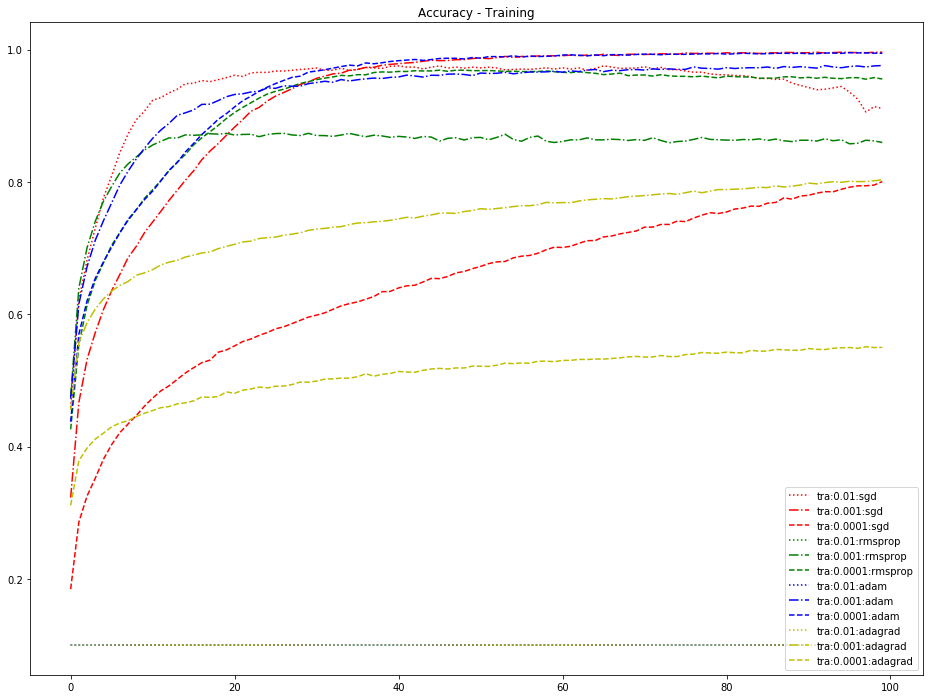

In [26]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(accu_result["tra:0.01:sgd"][0])),  accu_result["tra:0.01:sgd"][0],   ':' , label="tra:0.01:sgd",   color="r")
plt.plot(range(len(accu_result["tra:0.001:sgd"][0])), accu_result["tra:0.001:sgd"][0],  '-.', label="tra:0.001:sgd",  color="r")
plt.plot(range(len(accu_result["tra:0.0001:sgd"][0])),accu_result["tra:0.0001:sgd"][0], '--', label="tra:0.0001:sgd", color="r")

plt.plot(range(len(accu_result["tra:0.01:rmsprop"][0])),  accu_result["tra:0.01:rmsprop"][0],   ':' , label="tra:0.01:rmsprop",   color="g")
plt.plot(range(len(accu_result["tra:0.001:rmsprop"][0])), accu_result["tra:0.001:rmsprop"][0],  '-.', label="tra:0.001:rmsprop",  color="g")
plt.plot(range(len(accu_result["tra:0.0001:rmsprop"][0])),accu_result["tra:0.0001:rmsprop"][0], '--', label="tra:0.0001:rmsprop", color="g")

plt.plot(range(len(accu_result["tra:0.01:adam"][0])),  accu_result["tra:0.01:adam"][0],   ':' , label="tra:0.01:adam",   color="b")
plt.plot(range(len(accu_result["tra:0.001:adam"][0])), accu_result["tra:0.001:adam"][0],  '-.', label="tra:0.001:adam",  color="b")
plt.plot(range(len(accu_result["tra:0.0001:adam"][0])),accu_result["tra:0.0001:adam"][0], '--', label="tra:0.0001:adam", color="b")

plt.plot(range(len(accu_result["tra:0.01:adagrad"][0])),  accu_result["tra:0.01:adagrad"][0],   ':' , label="tra:0.01:adagrad",   color="y")
plt.plot(range(len(accu_result["tra:0.001:adagrad"][0])), accu_result["tra:0.001:adagrad"][0],  '-.', label="tra:0.001:adagrad",  color="y")
plt.plot(range(len(accu_result["tra:0.0001:adagrad"][0])),accu_result["tra:0.0001:adagrad"][0], '--', label="tra:0.0001:adagrad", color="y")

plt.title("Accuracy - Training")
plt.legend(loc="lower right")
plt.show()

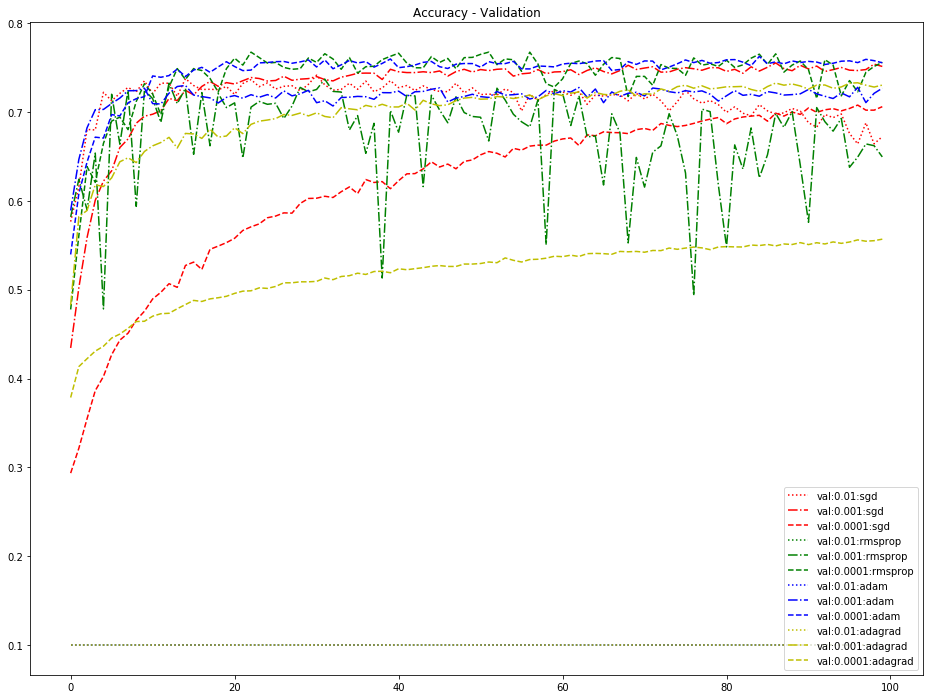

In [25]:
plt.figure(figsize=(16, 12))

plt.plot(range(len(accu_result["val:0.01:sgd"][0])),  accu_result["val:0.01:sgd"][0],   ':' , label="val:0.01:sgd",   color="r")
plt.plot(range(len(accu_result["val:0.001:sgd"][0])), accu_result["val:0.001:sgd"][0],  '-.', label="val:0.001:sgd",  color="r")
plt.plot(range(len(accu_result["val:0.0001:sgd"][0])),accu_result["val:0.0001:sgd"][0], '--', label="val:0.0001:sgd", color="r")

plt.plot(range(len(accu_result["val:0.01:rmsprop"][0])),  accu_result["val:0.01:rmsprop"][0],   ':' , label="val:0.01:rmsprop",   color="g")
plt.plot(range(len(accu_result["val:0.001:rmsprop"][0])), accu_result["val:0.001:rmsprop"][0],  '-.', label="val:0.001:rmsprop",  color="g")
plt.plot(range(len(accu_result["val:0.0001:rmsprop"][0])),accu_result["val:0.0001:rmsprop"][0], '--', label="val:0.0001:rmsprop", color="g")

plt.plot(range(len(accu_result["val:0.01:adam"][0])),  accu_result["val:0.01:adam"][0],   ':' , label="val:0.01:adam",   color="b")
plt.plot(range(len(accu_result["val:0.001:adam"][0])), accu_result["val:0.001:adam"][0],  '-.', label="val:0.001:adam",  color="b")
plt.plot(range(len(accu_result["val:0.0001:adam"][0])),accu_result["val:0.0001:adam"][0], '--', label="val:0.0001:adam", color="b")

plt.plot(range(len(accu_result["val:0.01:adagrad"][0])),  accu_result["val:0.01:adagrad"][0],   ':' , label="val:0.01:adagrad",   color="y")
plt.plot(range(len(accu_result["val:0.001:adagrad"][0])), accu_result["val:0.001:adagrad"][0],  '-.', label="val:0.001:adagrad",  color="y")
plt.plot(range(len(accu_result["val:0.0001:adagrad"][0])),accu_result["val:0.0001:adagrad"][0], '--', label="val:0.0001:adagrad", color="y")

plt.title("Accuracy - Validation")
plt.legend(loc="lower right")
plt.show()

In [10]:
## '-' solid line style
## '--' dashed line style
## '-.' dash-dot line style
## ':' dotted line style
## '.' point marker
## ',' pixel marker
## 'o' circle marker
## 'v' triangle_down marker
## '^' triangle_up marker
## '<' triangle_left marker
## '>' triangle_right marker
## '1' tri_down marker
## '2' tri_up marker
## '3' tri_left marker
## '4' tri_right marker
## 's' square marker
## 'p' pentagon marker
## '*' star marker
## 'h' hexagon1 marker
## 'H' hexagon2 marker
## '+' plus marker
## 'x' x marker
## 'D' diamond marker
## 'd' thin_diamond marker
## '|' vline marker
## '_' hline marker
## 
## 'b' blue
## 'g' green
## 'r' red
## 'c' cyan
## 'm' magenta
## 'y' yellow
## 'k' black
## 'w' white